In [12]:
import numpy as np
import torch
import gymnasium as gym
from gymnasium import spaces

import imageio
import os
import random
import copy

from Combined_Agent_Double.Dueling_DDQN_Agent import Dueling_DDQN_Agent
from Combined_Agent_Double.utils.random_agent import RandomAgent
from Combined_Agent_Double.utils.actions import MORE_ACTIONS
import Combined_Agent_Double.utils.stats_functions as sf

import hockey.hockey_env as h_env

from importlib import reload

In [2]:
SEED_TRAIN_1 = 7489
SEED_TRAIN_2 = 1312
SEEDS_TEST = [291 + i for i in range(10)]

seed = SEED_TRAIN_1

USE_MORE_ACTIONS = True

In [26]:
reload(h_env)
env_name = "../weights/random_training_5"
env = h_env.HockeyEnv()
h_env.HockeyEnv().seed(seed)

state_space = env.observation_space

if(USE_MORE_ACTIONS):
    action_space = spaces.Discrete(len(MORE_ACTIONS))
else: 
    action_space = env.discrete_action_space

agent = Dueling_DDQN_Agent(state_space, action_space, seed = seed, eps = 0.01, learning_rate = 0.0001, hidden_sizes = [256, 256], n_steps = 5)
agent.Q.load(env_name)

stats, losses = sf.load_stats(env_name)

Dueling DQN Network Architecture:
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Dueling DQN Network Architecture:
  Input Layer: (18)
  Hidden Layer 1: Linear(18, 256) -> Tanh
  Hidden Layer 2: Linear(256, 256) -> Tanh
  Value Stream: Linear(256, 1)
  Advantage Stream: Linear(256, 20)
------------------------------------------------------
Network loaded from ../weights/random_training_5/weights/training_finished.pth


Plot saved at ../weights/random_training_5/stats/plots/returns_plot.png


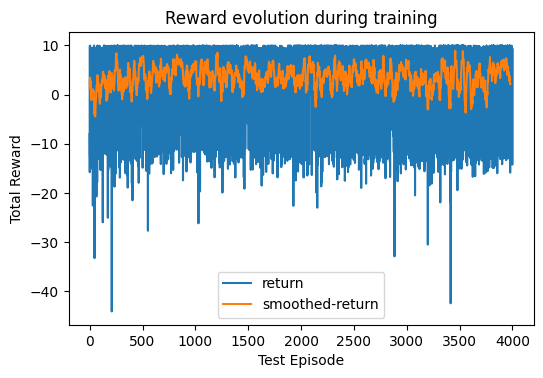

In [27]:
sf.plot_returns(stats, env_name)

Plot saved at ../weights/random_training_5/stats/plots/losses_plot.png


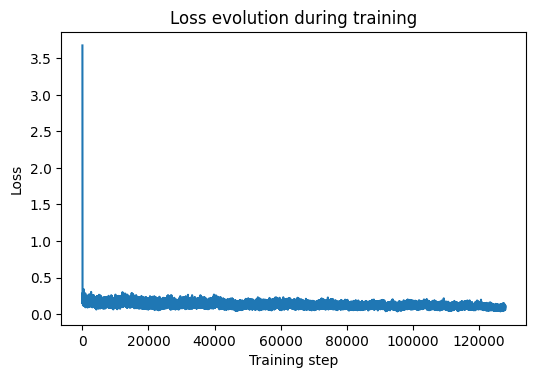

In [28]:
sf.plot_losses(losses, env_name)

Plot saved at ../weights/random_training_5/stats/plots/beta_evolution.png


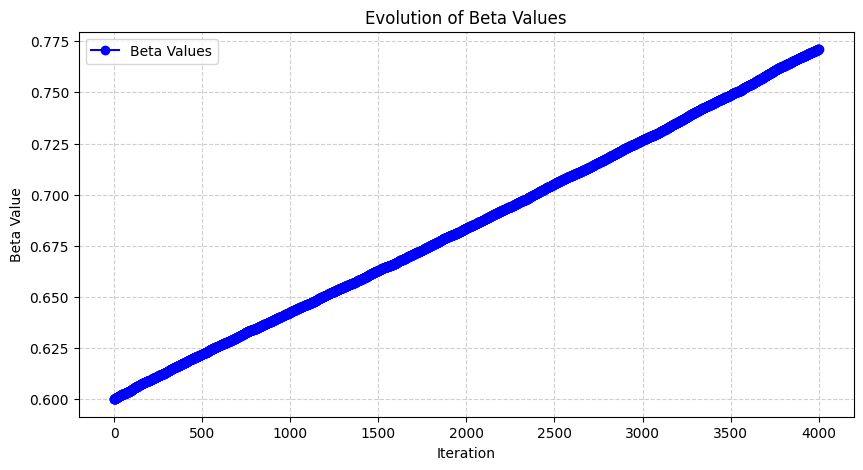

In [29]:
betas = sf.load_betas(env_name)
sf.plot_beta_evolution(env_name, betas)

Plot saved at ../weights/random_training_5/stats/plots/epsilon_evolution.png


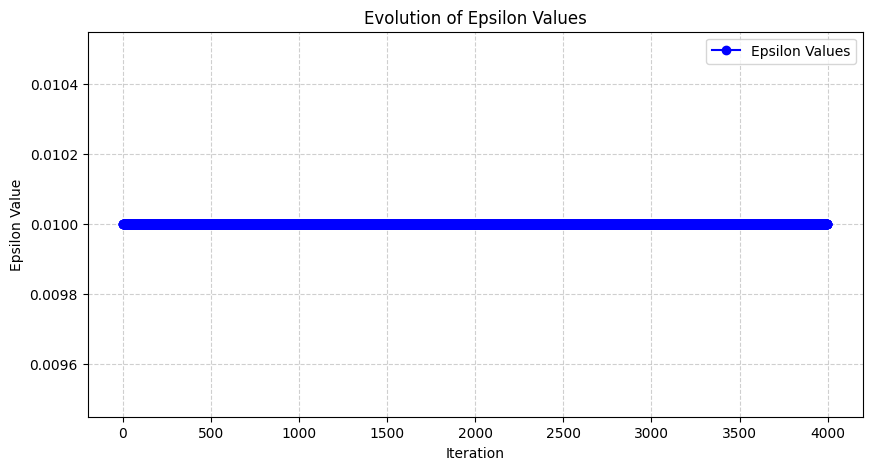

In [30]:
epsilons = sf.load_epsilons(env_name)
sf.plot_epsilon_evolution(env_name, epsilons)

In [31]:
match_history = sf.load_match_history(env_name)
sf.plot_match_evolution_by_chunks(env_name, match_history, ["Radom", "Weak", "NonWeak"], 50)

ModuleNotFoundError: No module named 'numpy._core'

Test Episode 1, Total Reward: 0.0
Test Episode 2, Total Reward: 9.385610751973012
Test Episode 3, Total Reward: 0.0
Test Episode 4, Total Reward: 9.352414080818036
Test Episode 5, Total Reward: 9.932264320590726
Test Episode 6, Total Reward: 9.311629770837868
Test Episode 7, Total Reward: -11.399901070422123
Test Episode 8, Total Reward: 5.426577813097256
Test Episode 9, Total Reward: 0.0
Test Episode 10, Total Reward: 9.528706904291651
Plot saved at ../weights/random_training_5/stats/plots/test_results.png


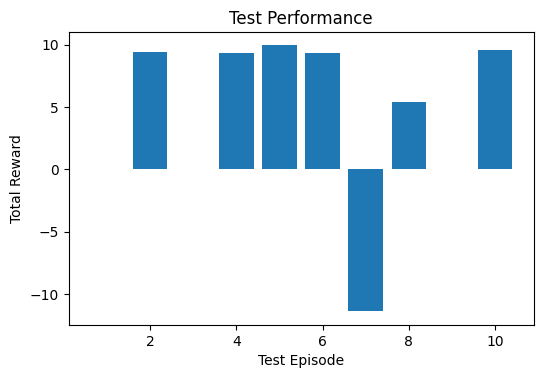

In [32]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = RandomAgent(seed)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/random", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/random/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_random")

Test Episode 1, Total Reward: -10.865842103830758
Test Episode 2, Total Reward: 9.397826629306675
Test Episode 3, Total Reward: -11.03281009809941
Test Episode 4, Total Reward: 8.357292205705892
Test Episode 5, Total Reward: 8.146608917800453
Test Episode 6, Total Reward: 9.53933046355408
Test Episode 7, Total Reward: -10.85724216889534
Test Episode 8, Total Reward: 9.186572021245611
Test Episode 9, Total Reward: 7.459814509527391
Test Episode 10, Total Reward: 9.55584148103378
Plot saved at ../weights/random_training_5/stats/plots/test_results.png


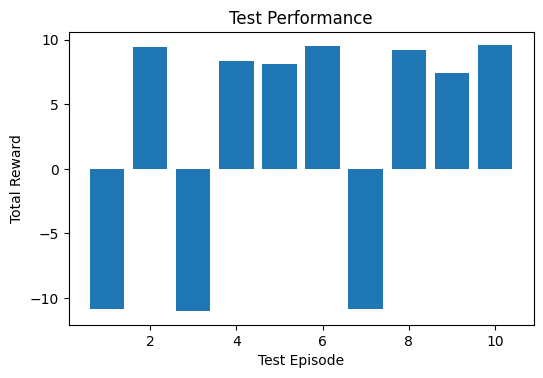

In [33]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = h_env.BasicOpponent()

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/weak", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/weak/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_weak")

Test Episode 1, Total Reward: 8.732082793245024
Test Episode 2, Total Reward: 9.547769362073081
Test Episode 3, Total Reward: 8.830795511656529
Test Episode 4, Total Reward: 9.518735162285138
Test Episode 5, Total Reward: 8.451185360480535
Test Episode 6, Total Reward: 9.420294645669214
Test Episode 7, Total Reward: 8.436217950746887
Test Episode 8, Total Reward: 9.106059546212942
Test Episode 9, Total Reward: 8.984943821980531
Test Episode 10, Total Reward: 9.525316528197134
Plot saved at ../weights/random_training_5/stats/plots/test_results.png


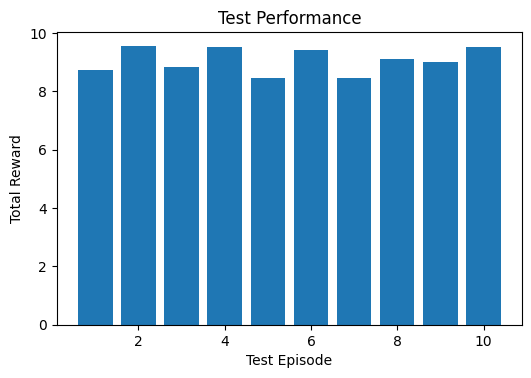

In [34]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = h_env.BasicOpponent(weak=False)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        #a1 = env.discrete_to_continous_action(agent.perform_greedy_action(state))
        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/nonweak", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/nonweak/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_nonweak")

Test Episode 1, Total Reward: -10.87911966384685
Test Episode 2, Total Reward: -15.469861911043308
Test Episode 3, Total Reward: 7.7549722870476465
Test Episode 4, Total Reward: 8.962742639277323
Test Episode 5, Total Reward: -14.261826318054878
Test Episode 6, Total Reward: 8.385997464488357
Test Episode 7, Total Reward: 8.786409063947408
Test Episode 8, Total Reward: 7.619972266524779
Test Episode 9, Total Reward: 8.982287997621112
Test Episode 10, Total Reward: 9.421660660994279
Plot saved at ../weights/random_training_5/stats/plots/test_results.png


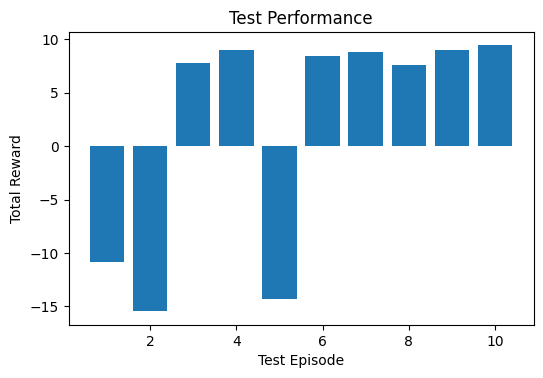

In [35]:
test_episodes = len(SEEDS_TEST)
test_rewards = []

opponent = copy.deepcopy(agent)

max_steps = 30000

for episode in range(test_episodes):

    state, _ = env.reset(seed = SEEDS_TEST[episode])
    state = state[0] if isinstance(state, tuple) else state  # Handle Gymnasium compatibility

    obs_agent2 = env.obs_agent_two()
    obs_agent2 = obs_agent2[0] if isinstance(obs_agent2, tuple) else obs_agent2

    total_reward = 0

    frames = []
    
    for t in range(max_steps):

        done = False

        frame = env.render(mode = "rgb_array")
        if frame is not None:
            frames.append(frame)

        a1 = agent.perform_greedy_action(state, eps = 0.0)
        a2 = opponent.act(obs_agent2)

        if(USE_MORE_ACTIONS):
            a1_cont = MORE_ACTIONS[a1]
            a2 = MORE_ACTIONS[a2]
        else: 
            a1_cont = env.discrete_to_continous_action(a1)
            a2 = env.discrete_to_continous_action(a2)

        full_action = np.hstack([a1_cont, a2])

        next_state, reward, done, truncated, _ = env.step(full_action)
        
        total_reward += reward

        state = next_state
        obs_agent2 = env.obs_agent_two()

        if done or truncated: break

    test_rewards.append(total_reward)
    print(f"Test Episode {episode+1}, Total Reward: {total_reward}")
    
    if frames:
        os.makedirs(f"{env_name}/test_gifs/selfplay", exist_ok=True)
        imageio.mimsave(f"{env_name}/test_gifs/selfplay/test_episode_{episode+1}.gif", frames, fps=30)

env.close()

sf.save_test_results(env_name, test_rewards, name = "test_results_selfplay")